In [1]:
!pip install gensim

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text
import numpy as np
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize 
import re

In [5]:
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim import corpora

In [6]:
df = pd.read_csv('cleaned_reddit_comments.csv')
docs = df['cleaned_comment'].dropna().astype(str).tolist()

In [7]:
remove_words = [
        'chatgpt', 'im', 'ive', 'thats','youre','day','word','thing','maybe','chat','gpt',
        'theyre','yeah','lol','u','sure','make','like','people','say','use','think',
        'fuck','shit','ai'
]
pattern = r'\b(?:' + '|'.join(remove_words) + r')\b'

docs_cleaned = []
for doc in docs:
    doc_lower = doc.lower()
    doc_nostop = re.sub(pattern, '', doc_lower)         
    doc_clean = re.sub(r'[^\w\s]', '', doc_nostop)  
    docs_cleaned.append(doc_clean)

In [8]:
vectorizer = CountVectorizer(
    max_df=0.8,  
    min_df=20,     
    stop_words='english'
)
X_bow = vectorizer.fit_transform(docs_cleaned)

K=2, coherence=0.7741
K=3, coherence=0.7342
K=4, coherence=0.7657
K=5, coherence=0.7177
K=6, coherence=0.6977
K=7, coherence=0.6438
K=8, coherence=0.6976
K=9, coherence=0.6596
K=10, coherence=0.6006


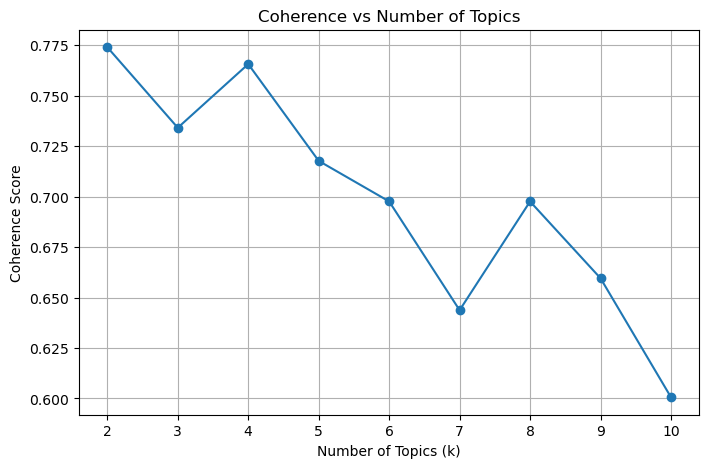

In [36]:
# CountVectorizer vocabulary to tokens
feature_names = vectorizer.get_feature_names_out()

#  BOW - Gensim 
texts = []
for row in X_bow.toarray():
    tokens = [feature_names[i] for i, v in enumerate(row) if v > 0]
    texts.append(tokens)

# gensim dictionary & corpus
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# coherence for k=2–10
from gensim.models.ldamodel import LdaModel

coherence_scores = []
k_values = range(2, 11)

for k in k_values:
    lda = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=k,
        random_state=42,
        chunksize=2000,
        passes=10,
        alpha='auto'
    )

    cm = CoherenceModel(
        model=lda,
        texts=texts,
        dictionary=id2word,
        coherence='c_v'
    )
    coherence_scores.append(cm.get_coherence())
    print(f"K={k}, coherence={cm.get_coherence():.4f}")

#  plot
plt.figure(figsize=(8,5))
plt.plot(k_values, coherence_scores, marker='o')
plt.xlabel("Number of Topics (k)")
plt.ylabel("Coherence Score")
plt.title("Coherence vs Number of Topics")
plt.xticks(k_values)
plt.grid(True)
plt.show()

K=2, perplexity=1399.55


Exception ignored in: <function ResourceTracker.__del__ at 0x10313dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1069e9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107e21bc0>
Traceback (most recent call last

K=3, perplexity=1390.70
K=4, perplexity=1392.87
K=5, perplexity=1403.38
K=6, perplexity=1402.81
K=7, perplexity=1418.46
K=8, perplexity=1418.63
K=9, perplexity=1417.97
K=10, perplexity=1422.74


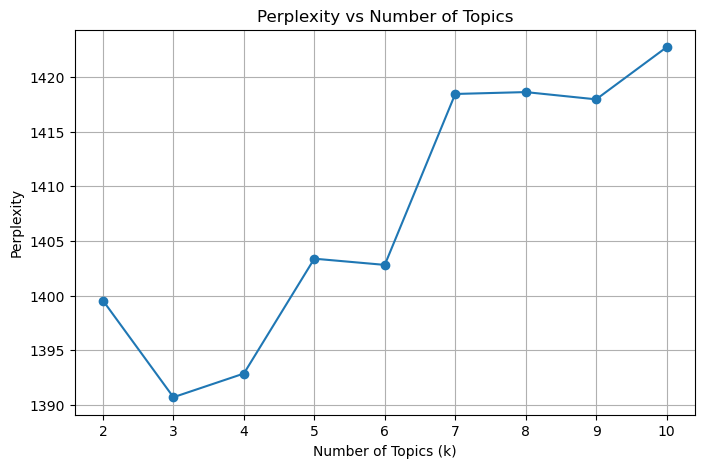

In [37]:
import numpy as np
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt

perplexity_scores = []

# k=2–10
k_values = range(2, 11)

for k in k_values:
    lda = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=k,
        random_state=42,
        chunksize=2000,
        passes=10,
        alpha='auto'
    )

    # Gensim log perplexity → convert to standard perplexity
    log_perp = lda.log_perplexity(corpus)
    perp = np.exp(-log_perp)

    perplexity_scores.append(perp)
    print(f"K={k}, perplexity={perp:.2f}")

plt.figure(figsize=(8,5))
plt.plot(k_values, perplexity_scores, marker='o')
plt.xlabel("Number of Topics (k)")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Number of Topics")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [13]:
topic_range = [4, 5, 6,7]   
n_runs = 10             
n_top_words = 5
max_iter = 30             
sample_size = 30000     

sample_idx = np.random.choice(X_bow.shape[0], sample_size, replace=False)
X_sample = X_bow[sample_idx]

sample_texts = [docs_cleaned[i] for i in sample_idx]         
sample_tokens = [txt.split() for txt in sample_texts]       

dictionary = Dictionary(sample_tokens)

feature_names = vectorizer.get_feature_names_out()

results = {} 

for n_topics in topic_range:
    print(f"\n=== n_topics = {n_topics} ===")
    run_coherences = []
    run_perplexities = []

    for run_idx in range(n_runs):
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=max_iter,
            learning_method='online',
            random_state=run_idx,
            n_jobs=-1 
        )
        lda.fit(X_sample)

        # top words
        topics_words = []
        print(f"\nRun {run_idx+1} Topic Keywords:")
        for t_idx, topic in enumerate(lda.components_):
            top_idxs = topic.argsort()[-n_top_words:][::-1]
            top_words = [feature_names[i] for i in top_idxs]
            topics_words.append(top_words)
            print(f"Topic {t_idx}: {top_words}")

        # Coherence (c_v)
        cm = CoherenceModel(
            topics=topics_words,
            texts=sample_tokens,  
            dictionary=dictionary,
            coherence='c_v'
        )
        coh = cm.get_coherence()
        run_coherences.append(coh)

        perp = lda.perplexity(X_sample)  
        run_perplexities.append(perp)

        print(f"Coherence (c_v): {coh:.4f}    Perplexity: {perp:.2f}")

    # avg
    avg_coh = np.mean(run_coherences)
    std_coh = np.std(run_coherences)
    avg_perp = np.mean(run_perplexities)
    std_perp = np.std(run_perplexities)

    results[n_topics] = {
        'coherences': run_coherences,
        'perplexities': run_perplexities,
        'avg_coherence': avg_coh,
        'std_coherence': std_coh,
        'avg_perplexity': avg_perp,
        'std_perplexity': std_perp
    }

    print(f"\nSummary for n_topics={n_topics}: "
          f"avg_coherence={avg_coh:.4f} (±{std_coh:.4f}), "
          f"avg_perplexity={avg_perp:.2f} (±{std_perp:.2f})")

print("\n=== Comparison ===")
for n in topic_range:
    r = results[n]
    print(f"n_topics={n} | coherence={r['avg_coherence']:.4f} (±{r['std_coherence']:.4f}) "
          f"| perplexity={r['avg_perplexity']:.2f} (±{r['std_perplexity']:.2f})")


=== n_topics = 4 ===

Run 1 Topic Keywords:
Topic 0: ['human', 'job', 'dont', 'feel', 'good']
Topic 1: ['write', 'ask', 'prompt', 'tell', 'question']
Topic 2: ['work', 'dont', 'learn', 'need', 'student']
Topic 3: ['google', 'year', 'search', 'pay', 'company']
Coherence (c_v): 0.6620    Perplexity: 1578.62

Run 2 Topic Keywords:
Topic 0: ['write', 'student', 'code', 'bot', 'test']
Topic 1: ['know', 'dont', 'good', 'human', 'really']
Topic 2: ['ask', 'google', 'answer', 'model', 'question']
Topic 3: ['work', 'learn', 'need', 'job', 'pay']
Coherence (c_v): 0.6830    Perplexity: 1630.45

Run 3 Topic Keywords:
Topic 0: ['pay', 'company', 'read', 'want', 'tell']
Topic 1: ['model', 'information', 'language', 'data', 'generate']
Topic 2: ['write', 'student', 'work', 'ask', 'code']
Topic 3: ['dont', 'google', 'know', 'work', 'answer']
Coherence (c_v): 0.6833    Perplexity: 1616.73

Run 4 Topic Keywords:
Topic 0: ['student', 'company', 'pay', 'school', 'talk']
Topic 1: ['model', 'ask', 'prompt'

In [10]:
n_topics = 4
max_iter = 80  

lda_final = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=max_iter,
    learning_method='online',
    random_state=42,
    n_jobs=-1
)

lda_final.fit(X_bow)

LatentDirichletAllocation(learning_method='online', max_iter=80, n_components=4,
                          n_jobs=-1, random_state=42)

In [13]:
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

for idx, topic in enumerate(lda_final.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
    print(f"Topic {idx}: {top_words}")

Topic 0: ['google', 'work', 'student', 'search', 'write', 'learn', 'need', 'good', 'isnt', 'dont']
Topic 1: ['ask', 'write', 'answer', 'know', 'dont', 'try', 'time', 'tell', 'job', 'want']
Topic 2: ['pay', 'company', 'year', 'world', 'let', 'mean', 'right', 'come', 'dont', 'money']
Topic 3: ['human', 'model', 'information', 'data', 'language', 'generate', 'text', 'bot', 'train', 'base']


In [1]:
pip install --upgrade pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pyLDAvis
import numpy as np

doc_topic_dists = lda_final.transform(X_bow)  
topic_term_dists = lda_final.components_    
vocab = vectorizer.get_feature_names_out()  
term_frequency = np.array(X_bow.sum(axis=0)).flatten()
doc_lengths = np.array(X_bow.sum(axis=1)).flatten()  


lda_vis = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    vocab=vocab,
    term_frequency=term_frequency,
    doc_lengths=doc_lengths
)


pyLDAvis.save_html(lda_vis, 'lda_visualization.html')

In [26]:
pyLDAvis.display(lda_vis) 

In [33]:
n_topics = 3
max_iter = 80  

lda_final = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=max_iter,
    learning_method='online',
    random_state=42,
    n_jobs=-1
)

lda_final.fit(X_bow)

LatentDirichletAllocation(learning_method='online', max_iter=80, n_components=3,
                          n_jobs=-1, random_state=42)

In [34]:
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

for idx, topic in enumerate(lda_final.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
    print(f"Topic {idx}: {top_words}")

Topic 0: ['write', 'ask', 'answer', 'question', 'prompt', 'tell', 'try', 'code', 'time', 'know']
Topic 1: ['google', 'dont', 'year', 'job', 'work', 'pay', 'time', 'good', 'want', 'know']
Topic 2: ['human', 'model', 'learn', 'student', 'work', 'way', 'need', 'tool', 'problem', 'data']


In [38]:
import pyLDAvis
import numpy as np

doc_topic_dists = lda_final.transform(X_bow)  
topic_term_dists = lda_final.components_     
vocab = vectorizer.get_feature_names_out()   
term_frequency = np.array(X_bow.sum(axis=0)).flatten()
doc_lengths = np.array(X_bow.sum(axis=1)).flatten() 

lda_vis = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    vocab=vocab,
    term_frequency=term_frequency,
    doc_lengths=doc_lengths
)

pyLDAvis.save_html(lda_vis, 'lda_visualization.html')

/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=20071) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=20071) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=20071) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=20071) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarnin

In [39]:
pyLDAvis.display(lda_vis) 